In this Notebook we will follow the same steps than Benchmark_and_RandomForest_Model Notebook  
but making some change manually to the data to test the robustness of RF model

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

In [3]:
train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

# Replace Date column by Week and Year column because we get one data per week
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Week'] = train_df.Date.apply(lambda x: x.weekofyear)
train_df['Year'] = train_df.Date.apply(lambda x: x.year)
train_df = train_df.drop(['Date'], axis=1)

# Set missing value to 0
train_df.fillna(0, inplace=True)

# Set negative sales to 0
train_df.loc[train_df['Weekly_Sales'] < 0, 'Weekly_Sales'] = 0

# In competition evaluation, weights in WMAE are 5 if week is holiday, 1 otherwise
train_df['IsHoliday'].replace([False,True], [1,5], inplace = True)

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year
0,1,1,24924.50,1,5,2010
1,1,1,46039.49,5,6,2010
2,1,1,41595.55,1,7,2010
3,1,1,19403.54,1,8,2010
4,1,1,21827.90,1,9,2010


## Change one point to a high value

In [16]:
# test robustness by changing weekly sales of week 25 to an about 10 times higher value
print(train_df.loc[(train_df.Store == 1) & (train_df.Dept == 4) & (train_df.Week == 25) & (train_df.Year == 2010),'Weekly_Sales'])
train_df.loc[(train_df.Store == 1) & (train_df.Dept == 4) & (train_df.Week == 25) & (train_df.Year == 2010),'Weekly_Sales'] = 300000
print(train_df.loc[(train_df.Store == 1) & (train_df.Dept == 4) & (train_df.Week == 25) & (train_df.Year == 2010),'Weekly_Sales'])

449    34454.69
Name: Weekly_Sales, dtype: float64
449    300000.0
Name: Weekly_Sales, dtype: float64


In [17]:
# create a copy of this dataframe to use it later in this original preprocessed form if needed
train_df2 = train_df.copy()

Look at the prediction for Store 1 Deparment 4

In [18]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]
week = 8

# Create a train dataframe with data from 2010 to week 8 in 2012
train2010 = train_df2[train_df2['Year'] == 2010]
train2011 = train_df2[train_df2['Year'] == 2011]
train2012 = train_df2[(train_df['Year'] == 2012) & (train_df2['Week'] < week)]
train = train2010.append(train2011).append(train2012)

# Create a test dataframe with data from week 8 in 2012 (to get our wanted 36 weeks)
test = train_df2[(train_df2['Week'] >= week) & (train_df2['Year'] == 2012)]

Weighted mean absolute error (WMAE) for Store 1 Dept 4 = 2877.6552150000093


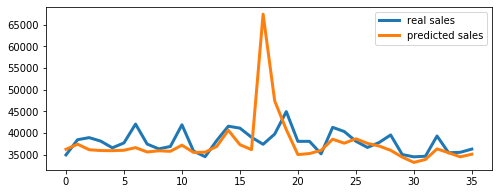

Global Weighted mean absolute error (WMAE) for these predicted series = 2877.6552150000093


In [19]:
store = 1
dept = 4
        
# Select train and test dataframe for the wanted store and dept
train_sd = train[(train.Store == store)&(train.Dept == dept)]
test_sd = test[(test.Store == store)&(test.Dept == dept)]

# Keep all data except Sales for xtrain and xtest
xtrain = train_sd.drop(['Weekly_Sales'], axis=1)
xtest = test_sd.drop(['Weekly_Sales'], axis=1)

# Keep only Sales for ytrain and ytest
ytrain = train_sd['Weekly_Sales'].values
ytest = test_sd['Weekly_Sales'].values

# Create a RandomForestRegressor model
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

# train the Random Forst model if there is data for training
if len(xtrain)>0:           
    rfr.fit(xtrain, ytrain)

    # make a prediction if there is an expected output
    if len(xtest)>0:
        pred = rfr.predict(xtest)

        # if there is an output, compute WMAE metric
        if len(pred)>0:
            xtest['weighted_error'] = xtest.IsHoliday * abs(ytest-pred)
            sum_weights = xtest.IsHoliday.sum()
            sum_weighted_error = xtest.weighted_error.sum()
            wmae = (1/sum_weights) * sum_weighted_error

            if str(wmae) != 'nan':
                # plot predictions
                print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
                plot_df = pd.DataFrame()
                plot_df['predicted_sales'] = pred
                plot_df['real_sales']=ytest
                plt.figure(figsize=(8,3))
                plot_df['real_sales'].plot(label='real sales', lw=3)
                plot_df['predicted_sales'].plot(label='predicted sales', lw=3)
                plt.legend()
                plt.show()

                total_sum_weights.append(sum_weights)
                total_sum_weighted_error.append(sum_weighted_error)

# Global WMAE for our model will be printed at the end
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

The model takes this value into account and we can see the prediction becoming much higher for this week particular week.  
Next we test another change  
We set to 0 all the value of 2010 sales for this Store 1 department 4

## Set to zero all sales of 2010

In [20]:
# Set all weekly sales of 2010 to 0 for Store 1 department 4
train_df.loc[(train_df.Store == 1) & (train_df.Dept == 4) & (train_df.Year == 2010),'Weekly_Sales'] = 0

In [21]:
# create a copy of this dataframe to use it later in this original preprocessed form if needed
train_df2 = train_df.copy()

In [22]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]
week = 8

# Create a train dataframe with data from 2010 to week 8 in 2012
train2010 = train_df2[train_df2['Year'] == 2010]
train2011 = train_df2[train_df2['Year'] == 2011]
train2012 = train_df2[(train_df2['Year'] == 2012) & (train_df2['Week'] < week)]
train = train2010.append(train2011).append(train2012)

# Create a test dataframe with data from week 8 in 2012 (to get our wanted 36 weeks)
test = train_df2[(train_df2['Week'] >= week) & (train_df2['Year'] == 2012)]

Weighted mean absolute error (WMAE) for Store 1 Dept 4 = 1850.4405175000118


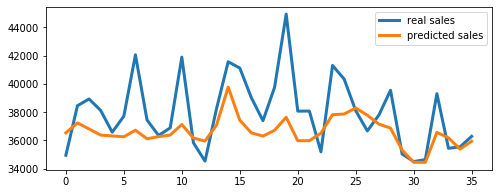

Global Weighted mean absolute error (WMAE) for these predicted series = 1850.4405175000118


In [23]:
store = 1
dept = 4
        
# Select train and test dataframe for the wanted store and dept
train_sd = train[(train.Store == store)&(train.Dept == dept)]
test_sd = test[(test.Store == store)&(test.Dept == dept)]

# Keep all data except Sales for xtrain and xtest
xtrain = train_sd.drop(['Weekly_Sales'], axis=1)
xtest = test_sd.drop(['Weekly_Sales'], axis=1)

# Keep only Sales for ytrain and ytest
ytrain = train_sd['Weekly_Sales'].values
ytest = test_sd['Weekly_Sales'].values

# Create a RandomForestRegressor model
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

# train the Random Forst model if there is data for training
if len(xtrain)>0:           
    rfr.fit(xtrain, ytrain)

    # make a prediction if there is an expected output
    if len(xtest)>0:
        pred = rfr.predict(xtest)

        # if there is an output, compute WMAE metric
        if len(pred)>0:
            xtest['weighted_error'] = xtest.IsHoliday * abs(ytest-pred)
            sum_weights = xtest.IsHoliday.sum()
            sum_weighted_error = xtest.weighted_error.sum()
            wmae = (1/sum_weights) * sum_weighted_error

            if str(wmae) != 'nan':
                # plot predictions
                print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
                plot_df = pd.DataFrame()
                plot_df['predicted_sales'] = pred
                plot_df['real_sales']=ytest
                plt.figure(figsize=(8,3))
                plot_df['real_sales'].plot(label='real sales', lw=3)
                plot_df['predicted_sales'].plot(label='predicted sales', lw=3)
                plt.legend()
                plt.show()

                total_sum_weights.append(sum_weights)
                total_sum_weighted_error.append(sum_weighted_error)

# Global WMAE for our model will be printed at the end
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

Predictions stay coherent and don’t change too much. In this particular case, we even get better WMAE than with sales of 2010

## Set to 0 sales from the 2 previous years

In [4]:
# Set all weekly sales of 2010 and 2011 to 0 for Store 1 department 4
train_df.loc[(train_df.Store == 1) & (train_df.Dept == 4) & (train_df.Year != 2012),'Weekly_Sales'] = 0

In [5]:
# create a copy of this dataframe to use it later in this original preprocessed form if needed
train_df2 = train_df.copy()

In [6]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]
week = 8

# Create a train dataframe with data from 2010 to week 8 in 2012
train2010 = train_df2[train_df2['Year'] == 2010]
train2011 = train_df2[train_df2['Year'] == 2011]
train2012 = train_df2[(train_df2['Year'] == 2012) & (train_df2['Week'] < week)]
train = train2010.append(train2011).append(train2012)

# Create a test dataframe with data from week 8 in 2012 (to get our wanted 36 weeks)
test = train_df2[(train_df2['Week'] >= week) & (train_df2['Year'] == 2012)]

Weighted mean absolute error (WMAE) for Store 1 Dept 4 = 1982.9615125000078


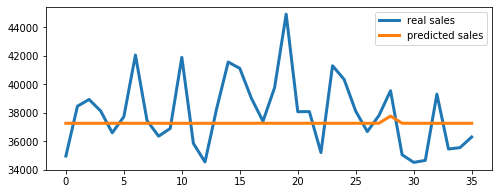

Global Weighted mean absolute error (WMAE) for these predicted series = 1982.9615125000078


In [7]:
store = 1
dept = 4
        
# Select train and test dataframe for the wanted store and dept
train_sd = train[(train.Store == store)&(train.Dept == dept)]
test_sd = test[(test.Store == store)&(test.Dept == dept)]

# Keep all data except Sales for xtrain and xtest
xtrain = train_sd.drop(['Weekly_Sales'], axis=1)
xtest = test_sd.drop(['Weekly_Sales'], axis=1)

# Keep only Sales for ytrain and ytest
ytrain = train_sd['Weekly_Sales'].values
ytest = test_sd['Weekly_Sales'].values

# Create a RandomForestRegressor model
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

# train the Random Forst model if there is data for training
if len(xtrain)>0:           
    rfr.fit(xtrain, ytrain)

    # make a prediction if there is an expected output
    if len(xtest)>0:
        pred = rfr.predict(xtest)

        # if there is an output, compute WMAE metric
        if len(pred)>0:
            xtest['weighted_error'] = xtest.IsHoliday * abs(ytest-pred)
            sum_weights = xtest.IsHoliday.sum()
            sum_weighted_error = xtest.weighted_error.sum()
            wmae = (1/sum_weights) * sum_weighted_error

            if str(wmae) != 'nan':
                # plot predictions
                print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
                plot_df = pd.DataFrame()
                plot_df['predicted_sales'] = pred
                plot_df['real_sales']=ytest
                plt.figure(figsize=(8,3))
                plot_df['real_sales'].plot(label='real sales', lw=3)
                plot_df['predicted_sales'].plot(label='predicted sales', lw=3)
                plt.legend()
                plt.show()

                total_sum_weights.append(sum_weights)
                total_sum_weighted_error.append(sum_weighted_error)

# Global WMAE for our model will be printed at the end
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

The prediction is really poor but take previous weeks of 2012 into account to get a prediction in the average